# Data analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from statistics import mean

## Constants

In [2]:
# PATHS
PROJECT_PATH=".."
DATA_PATH=f"{PROJECT_PATH}/data"
FIGURES_PATH=f"{PROJECT_PATH}/results/figures"
# scripts_path=f"{project_path}/scripts"

# I     # Frist ID
n=16    # number of items
N=100   # number of instances
m=0.8   # ratio of capacity/total_weight
W=5000  # max weight of an item 
w="bal" # more light or heavy items, or balanced
C=5000  # max value of an item
c="uni" # weith,value correlation
k=1     # granularity exponent

NS_VALUES=[1, 4, 7, 10, 13, 16, 19, 22, 25, 28] # [1, 4, 7, 10, 13, 16, 19, 22, 23, 26] # [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
MS_VALUES=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
BIG_WS_VALUES=[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
WS_VALUES=["bal", "light", "heavy"]
BIG_CS_VALUES=[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
CS_VALUES=["uni", "corr", "strong"]
KS_VALUES=[["light", "heavy"], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]]
PS_VALUES=[0,1,2,3,4,5,6,7,8,9]


## Parameter Test

In [3]:
class ParamTest:
    figures_path=f"{PROJECT_PATH}/results/figures/test"
    inst_suffix  = "inst.csv"
    sol_suffix  = "sol.csv"
    
    methods = {"1":"bf", "2":"bab", "3":"dp", "4":"gh", "5":"redux"}
    
    inst_columns = ["ID", "n", "W", "weights", "values", "max_value"]
    sol_columns = ["ID", "n", "max_value", "solution", "time", "error", "method"]
    stats_columns = ["n", "N", "m", "W", "w", "C", "c", "k", "time_max", "time_mean", "error_max", "error_mean"]

    def __init__(self, params, values, path):
        self.params = params if (isinstance(params, list) and isinstance(params[0], str)) else [params]
        self.values = values if (isinstance(values, list) and isinstance(values[0], list)) else [values]
        self.path = path
        
        self.inst_df = pd.DataFrame(columns=self.inst_columns)
        self.sol_df = pd.DataFrame(columns=self.sol_columns)
        self.stats_df = pd.DataFrame(columns=self.stats_columns)
        
        self.loadInstances()
        self.loadSolutions()

        self.calculateMaxValue()
        self.calulateMeanWeightAndValue()
        self.calculateRelativeError()
        self.loadStats()


    def __repr__(self):
        return f"ParamTest - self.params: {self.params}, self.path: {self.path}, self.values:{self.values}"


    def appendInstDataframe(self, in_file, **kwargs):
        df = pd.read_csv(in_file, sep=' ', header=None)

        df.columns = [str(x) for x in df.columns]
        df = df.rename(columns = {"0": "ID", "1": "n", "2": "W"})
        df["weights"] = df.apply(lambda x: list(x[df.columns[3::2]]), axis=1)
        df["values"] = df.apply(lambda x: list(x[df.columns[4::2]]), axis=1)
        df = df.drop(df.columns[3:-2], axis=1)
        
        for key, value in kwargs.items():
            df[key] = value

        self.inst_df = pd.concat([self.inst_df, df])

        
    def loadInstances(self):
        for p in product(*[self.params[-1:], *self.values, [self.inst_suffix]]):
            inst_file = f"{self.path}/{'_'.join([str(i) for i in p])}"
            params_len = len(self.params)
            kwargs = dict(zip(self.params, p[1 : (1+len(self.values))]))
            self.appendInstDataframe(inst_file, **kwargs)
    
    
    def appendSolDataframe(self, tmp_file, **kwargs):
        df = pd.read_csv(tmp_file, sep=' ', header=None)
        
        df.columns = [str(x) for x in df.columns]
        df = df.rename(columns = {"0": "ID", "1": "n", "2": "max_value", df.columns[-1]: "time"})
        df["solution"] = df.apply(lambda x: list(x[df.columns[3:3+df["n"][0]]]), axis=1)
        df = df.drop(df.columns[3:-2], axis=1)
        
        for key, value in kwargs.items():
            df[key] = value

        self.sol_df = pd.concat([self.sol_df, df])
        
        
    def loadSolutions(self):
        for p in product(*[self.params[-1:], self.methods.values(), *self.values, [self.sol_suffix]]):
            sol_file = f"{self.path}/{'_'.join([str(i) for i in p])}"
            params_len = len(self.params)
            kwargs = dict(zip(["method", *self.params], p[1 : (1+1+len(self.values))]))
            self.appendSolDataframe(sol_file, **kwargs)

    def calulateMeanWeightAndValue(self):
        self.inst_df["mean_weight"] = self.inst_df["weights"].apply(mean)
        self.inst_df["mean_value"] = self.inst_df["values"].apply(mean)

    def calculateMaxValue(self):
        flawless_method = "bf"
        self.inst_df["max_value"] = self.sol_df[self.sol_df["method"] == flawless_method]["max_value"]
        
    def calculateRelativeError(self):
        
        def getMaxValue(self, x):
            param_filter = self.inst_df["ID"] == x["ID"]
            for param in self.params:
                param_filter = param_filter & (self.inst_df[param] == x[param])
            
            return self.inst_df[param_filter]["max_value"].values[0]
        
        def calculate(max_value, computed_value):
            difference = abs(max_value - computed_value)
            max_value = max(max_value, computed_value)
            assert(difference == 0 or max_value > 0), f"difference = {difference} and max_value = {max_value}"
            rel_error = difference/max_value if (max_value > 0) else 0
            return rel_error            
        
        self.sol_df["error"] = self.sol_df.apply(lambda x: 
            calculate(getMaxValue(self, x), x["max_value"]), axis=1)

    def loadStats(self):
        df = self.sol_df.copy()

        df = df[[*self.params, "method", "time", "error"]].groupby(["method", *self.params])
        df = df.agg(['mean', 'max'])
        df.columns = [f"{col[0]}_{col[1]}" for col in df.columns]
        df = df.reset_index()

        self.stats_df = df

    
    def loadDf(self):
        self.loadInstances()
        self.loadSolutions()

    def seeHistogram(self, feature, method, **values):
        hist_filter = self.sol_df["method"] == method
        for key, value in values.items():
            hist_filter = hist_filter & (self.sol_df[key] == value)

        ax = sns.distplot(self.sol_df[hist_filter][feature], kde=False, label=str(values))
        ax.set_title(f"{feature.capitalize()} histogram, method: {method}, params: {values}")
        
        for label in ax.get_xticklabels():
            label.set_rotation(45)
        
        fig = ax.get_figure()
        fig_name = f"hist_{feature}_{method}_{'_'.join([f'{k}_{v}' for k,v in values.items()])}".replace(".", "")
        fig.savefig(f"{self.figures_path}/{fig_name}.png")
            
    def seeTimeHistogram(self, method, **values):
        self.seeHistogram("time", method, **values)
    
    def seeErrorHistogram(self, method, **values):
        self.seeHistogram("error", method, **values)

    def seeBarplot(self, feature):
        df = self.stats_df
        if len(self.params) == 1:
            g = sns.FacetGrid(df, col="method", sharey=False)
        else:
            g = sns.FacetGrid(df, col="method", row=self.params[0], sharey=False, sharex=False)
        g.map(sns.barplot, self.params[-1], f"{feature}_max", color="firebrick", order=self.values[-1], label="max")
        g.map(sns.barplot, self.params[-1], f"{feature}_mean", color="tab:blue", order=self.values[-1], label="mean")
        
        for ax in g.axes.flat:
            for label in ax.get_xticklabels():
                label.set_rotation(45)
        plt.legend()
        g.savefig(f"{self.figures_path}/{self.params[-1]}_{feature}.png")
        
    
    def seeTimeBarplot(self):
        self.seeBarplot("time")

    def seeErrorBarplot(self):
        self.seeBarplot("error")

        
    def seeBoxplot(self, feature, method, **values):
        param_filter = self.sol_df["method"] == method
        for key, value in values.items():
            param_filter = param_filter & (self.sol_df[key] == value)

        fig = sns.boxplot(y=self.params[-1], x=feature, orient="h" ,data=self.sol_df[param_filter])
#         fig.savefig(f"{self.figures_path}/{self.params[-1]}_{feature}.png"))

    def seeBoxplotFull(self, feature):
        df = self.sol_df
        if len(self.params) == 1:
            g = sns.FacetGrid(df, col="method", sharey=False)
        else:
            g = sns.FacetGrid(df, col="method", row=self.params[0], sharey=False,sharex=False)
            
        meanprops={"marker":"o", "markerfacecolor":"white", 
            "markeredgecolor":"black","markersize":"10"}
        
        g.map(sns.boxplot, self.params[-1], feature, order=self.values[-1], showmeans=True, meanprops=meanprops)
        
        for ax in g.axes.flat:
            for label in ax.get_xticklabels():
                label.set_rotation(45)
        g.savefig(f"{self.figures_path}/boxplot_{self.params[-1]}_{feature}.png")
        
    def seeTimeBoxplot(self, method, **values):
        self.seeBoxplot("time", method, **values)
        
    def seeErrorBoxplot(self, method, **values):
        self.seeBoxplot("error", method, **values)

## Number of Items

- bf - exponencial, robust
- bab - exponencial, robust
- dp - polynomial, robust
- gh - linear, 

In [4]:
data_ns = ParamTest("n", path=f"{DATA_PATH}/ns", values=NS_VALUES)

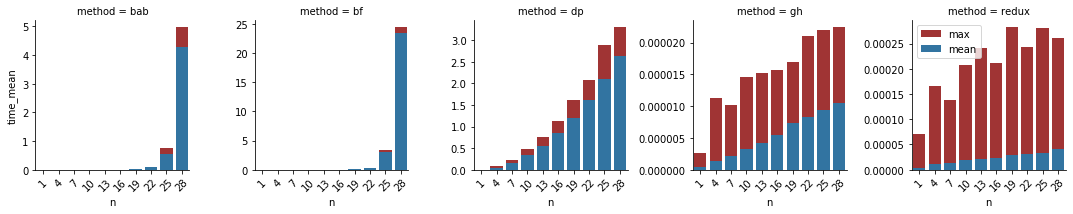

In [5]:
data_ns.seeTimeBarplot()

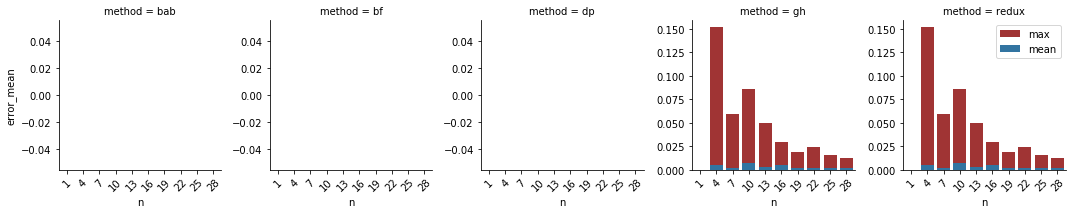

In [7]:
data_ns.seeErrorBarplot()

## Capacity / Total Items Weight

In [8]:
data_ms = ParamTest("m", path=f"{DATA_PATH}/ms", values=MS_VALUES)

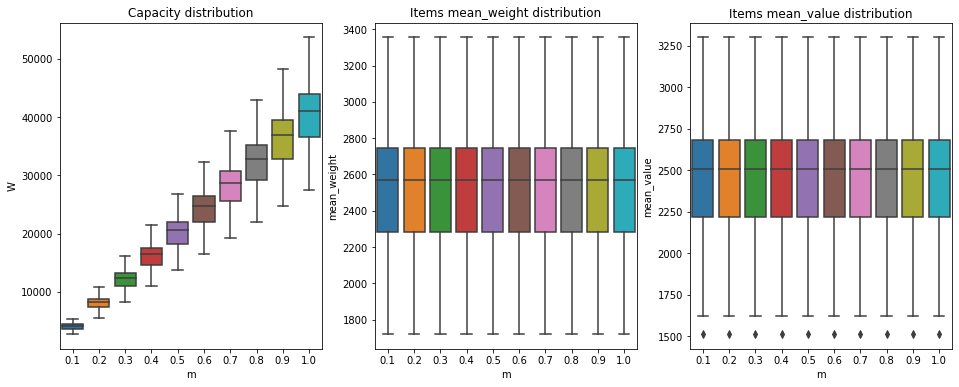

In [9]:
df = data_ms.inst_df
feature="m"

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(16, 6)

axes[0].set_title(f"Capacity distribution")
sns.boxplot(x=feature, y="W", data= df, ax=axes[0])

axes[1].set_title(f"Items mean_weight distribution")
sns.boxplot(x=feature, y="mean_weight", data= df, ax=axes[1])

axes[2].set_title(f"Items mean_value distribution")
ax = sns.boxplot(x=feature, y="mean_value", data= df, ax=axes[2])

plt.savefig(f"{data_ms.figures_path}/distributions_capacity_total_weight_ratio.png")

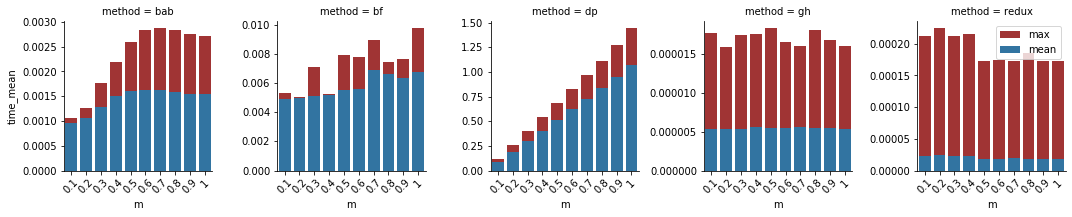

In [10]:
data_ms.seeTimeBarplot()

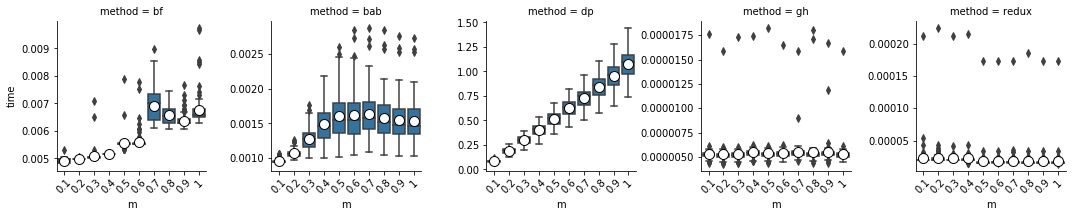

In [11]:
data_ms.seeBoxplotFull("time")

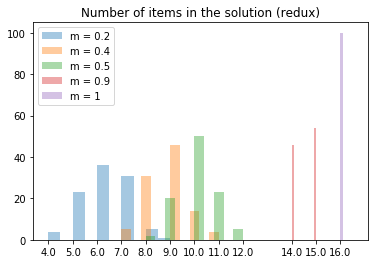

In [12]:
df = data_ms.sol_df
method = "redux"
# method = "gh"

arr_m_02 = []
for l in df[(df["method"] == method) & (df["m"] == 0.2) ]["solution"].values:
    arr_m_02.append(sum(l))
xticks = list(set(arr_m_02))
ax = sns.distplot(arr_m_02,bins=10, kde=False, label="m = 0.2")

arr_m_04 = []
for l in df[(df["method"] == method) & (df["m"] == 0.4) ]["solution"].values:
    arr_m_04.append(sum(l))
xticks.extend(list(set(arr_m_04)))
ax = sns.distplot(arr_m_04,bins=10, kde=False, label="m = 0.4")

arr_m_05 = []
for l in df[(df["method"] == method) & (df["m"] == 0.5) ]["solution"].values:
    arr_m_05.append(sum(l))
xticks.extend(list(set(arr_m_05)))
ax = sns.distplot(arr_m_05, bins=10, kde=False, label="m = 0.5", ax=ax)

arr_m_09 = []
for l in df[(df["method"] == method) & (df["m"] == 0.9) ]["solution"].values:
    arr_m_09.append(sum(l))
xticks.extend(list(set(arr_m_09)))
ax = sns.distplot(arr_m_09, bins=10, kde=False, label="m = 0.9", ax=ax)


arr_m_1 = []
for l in df[(df["method"] == method) & (df["m"] == 1) ]["solution"].values:
    arr_m_1.append(sum(l))
xticks.extend(list(set(arr_m_1)))
ax = sns.distplot(arr_m_1,bins=10, kde=False, label="m = 1")


xticks = list(set(xticks))
ax.set(xticks=xticks, xticklabels=xticks)
ax.set_title(f"Number of items in the solution ({method})")

plt.legend()
plt.savefig(f"{data_ms.figures_path}/m_number_of_items_in_solution_{method}.png")


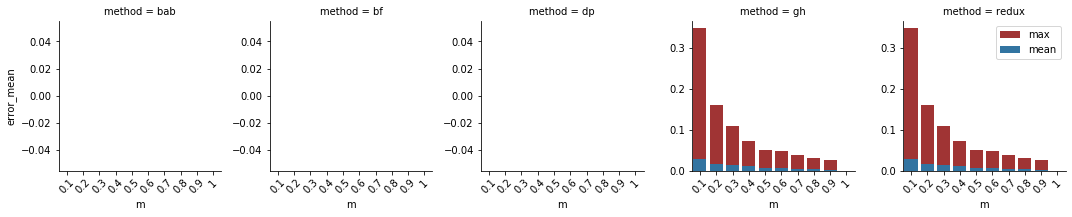

In [15]:
data_ms.seeErrorBarplot()

## Value/Weight Correlation

In [17]:
data_cs = ParamTest("c", path=f"{DATA_PATH}/cs", values=CS_VALUES)

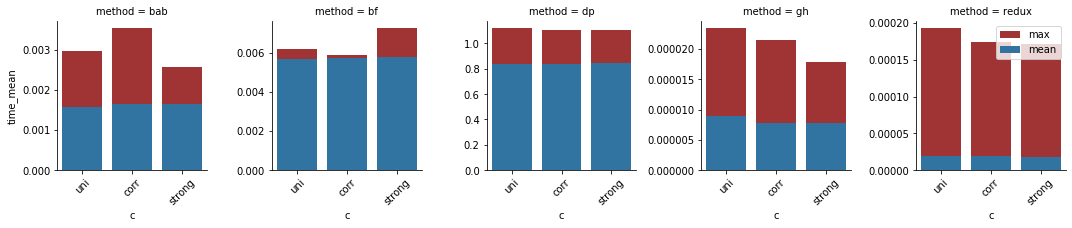

In [19]:
data_cs.seeTimeBarplot()

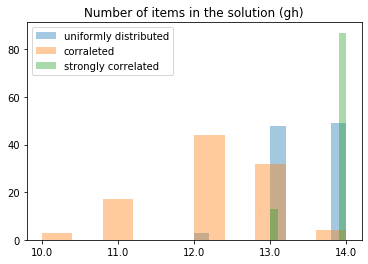

In [24]:
df = data_cs.sol_df
# method = "redux"
method = "gh"

arr_c_uni = []
for l in df[(df["method"] == method) & (df["c"] == "uni") ]["solution"].values:
    arr_c_uni.append(sum(l))
xticks = list(set(arr_c_uni))
ax = sns.distplot(arr_c_uni, bins=10, kde=False, label="uniformly distributed")

arr_c_corr = []
for l in df[(df["method"] == method) & (df["c"] == "corr") ]["solution"].values:
    arr_c_corr.append(sum(l))
xticks.extend(list(set(arr_c_corr)))
ax = sns.distplot(arr_c_corr, bins=10, kde=False, label="corraleted")

arr_c_strong = []
for l in df[(df["method"] == method) & (df["c"] == "strong") ]["solution"].values:
    arr_c_strong.append(sum(l))
xticks.extend(list(set(arr_c_strong)))
ax = sns.distplot(arr_c_strong, bins=10, kde=False, label="strongly correlated", ax=ax)


xticks = list(set(xticks))
ax.set(xticks=xticks, xticklabels=xticks)
ax.set_title(f"Number of items in the solution ({method})")

plt.legend()
plt.savefig(f"{data_ms.figures_path}/c_number_of_items_in_solution_{method}.png")


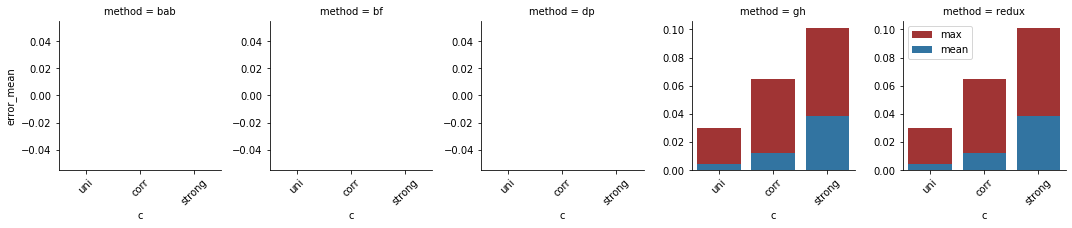

In [26]:
data_cs.seeErrorBarplot()

## Weight Distribution

In [28]:
data_ws = ParamTest("w", path=f"{DATA_PATH}/ws", values=WS_VALUES)

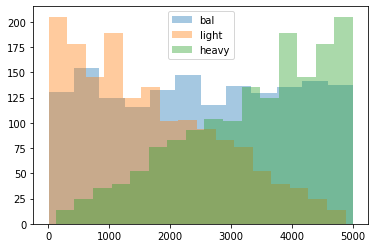

In [29]:
df = data_ws.inst_df

arr_bal = []
for l in df[df["w"] == "bal"]["weights"].values:
    arr_bal.extend(l)
sns.distplot(arr_bal, kde=False, label="bal")

arr_light = []
for l in df[df["w"] == "light"]["weights"].values:
    arr_light.extend(l)
sns.distplot(arr_light, kde=False, label="light")

arr_heavy = []
for l in df[df["w"] == "heavy"]["weights"].values:
    arr_heavy.extend(l)
sns.distplot(arr_heavy, kde=False, label="heavy")

plt.legend()
plt.savefig(f"{data_ws.figures_path}/weight_distributions")

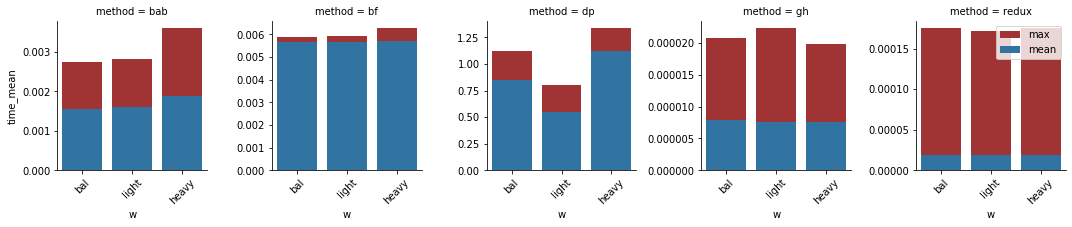

In [32]:
data_ws.seeTimeBarplot()

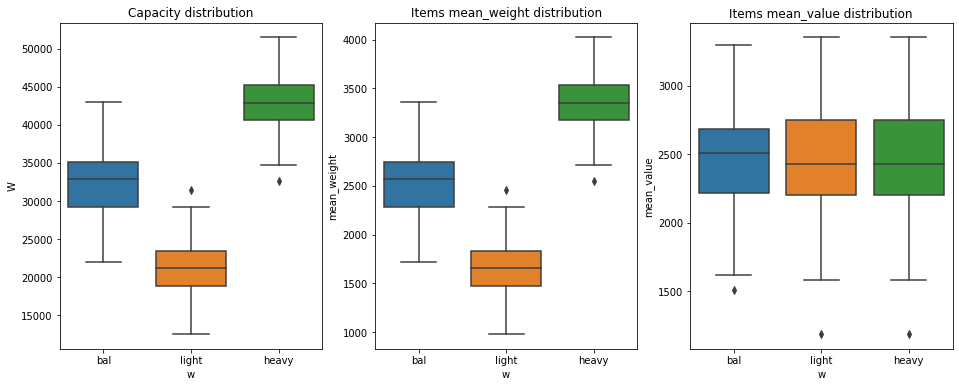

In [31]:
df = data_ws.inst_df
feature="w"

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(16, 6)

axes[0].set_title(f"Capacity distribution")
sns.boxplot(x=feature, y="W", data= df, ax=axes[0])

axes[1].set_title(f"Items mean_weight distribution")
sns.boxplot(x=feature, y="mean_weight", data= df, ax=axes[1])

axes[2].set_title(f"Items mean_value distribution")
ax = sns.boxplot(x=feature, y="mean_value", data= df, ax=axes[2])

plt.savefig(f"{data_ms.figures_path}/w_distributions_capacity_total_weight_ratio.png")

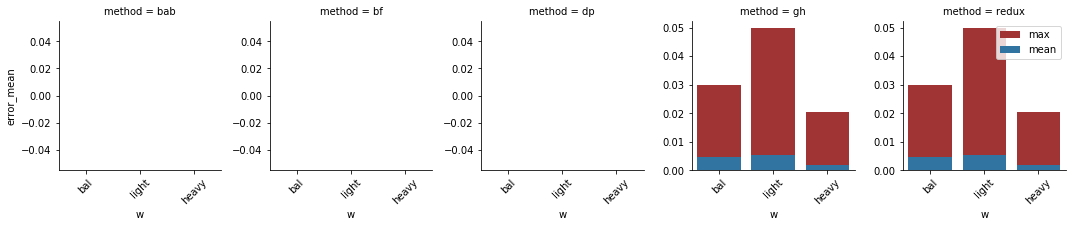

In [34]:
data_ws.seeErrorBarplot()

## Granularity

In [36]:
data_ks = ParamTest(["w","k"], path=f"{DATA_PATH}/ks", values=KS_VALUES)

In [37]:
df = data_ks.inst_df

display(
    df[df["w"] == "light"]["W"].min(),
    df[df["w"] == "heavy"]["W"].min()
)

10822

21160

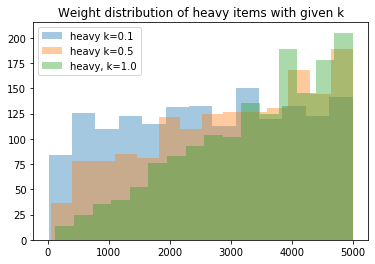

In [40]:
df = data_ks.inst_df

arr_heavy_01 = []
for l in df[(df["w"] == "heavy") & (df["k"] == 0.1)]["weights"].values:
    arr_heavy_01.extend(l)
sns.distplot(arr_heavy_01, kde=False, label="heavy k=0.1")

arr_heavy_05 = []
for l in df[(df["w"] == "heavy") & (df["k"] == 0.5)]["weights"].values:
    arr_heavy_05.extend(l)
sns.distplot(arr_heavy_05, kde=False, label="heavy k=0.5")

arr_heavy = []
for l in df[(df["w"] == "heavy") & (df["k"] == 1)]["weights"].values:
    arr_heavy.extend(l)
ax = sns.distplot(arr_heavy, kde=False, label="heavy, k=1.0")
ax.set_title("Weight distribution of heavy items with given k")

plt.legend()
plt.savefig(f"{data_ws.figures_path}/weight_distributions_with_k")

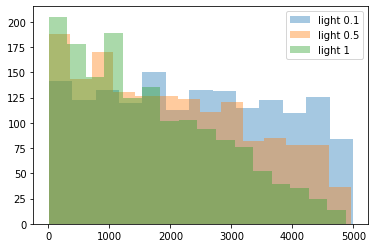

In [41]:
df = data_ks.inst_df

arr_light_01 = []
for l in df[(df["w"] == "light") & (df["k"] == 0.1)]["weights"].values:
    arr_light_01.extend(l)
sns.distplot(arr_light_01, kde=False, label="light 0.1")

arr_light_05 = []
for l in df[(df["w"] == "light") & (df["k"] == 0.5)]["weights"].values:
    arr_light_05.extend(l)
sns.distplot(arr_light_05, kde=False, label="light 0.5")

arr_light = []
for l in df[(df["w"] == "light") & (df["k"] == 1)]["weights"].values:
    arr_light.extend(l)
sns.distplot(arr_light, kde=False, label="light 1")

plt.legend()

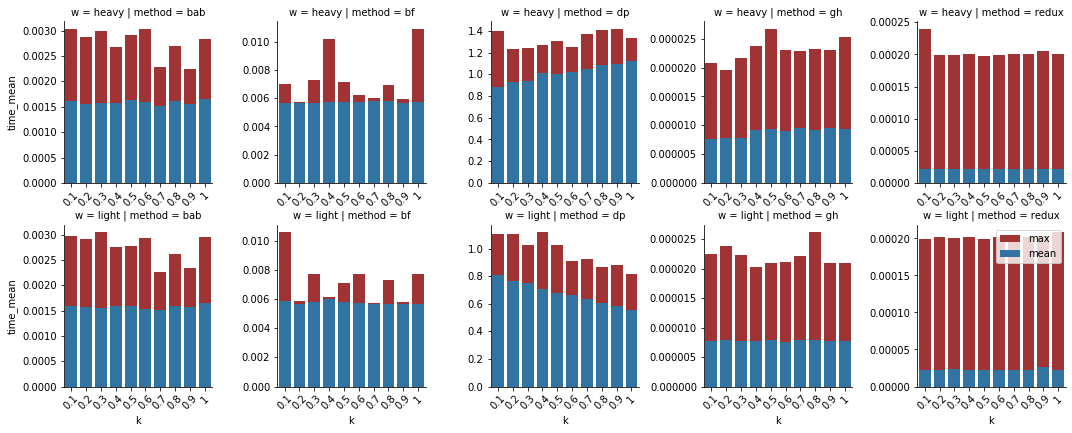

In [43]:
data_ks.seeTimeBarplot()

# data_ks.stats_df

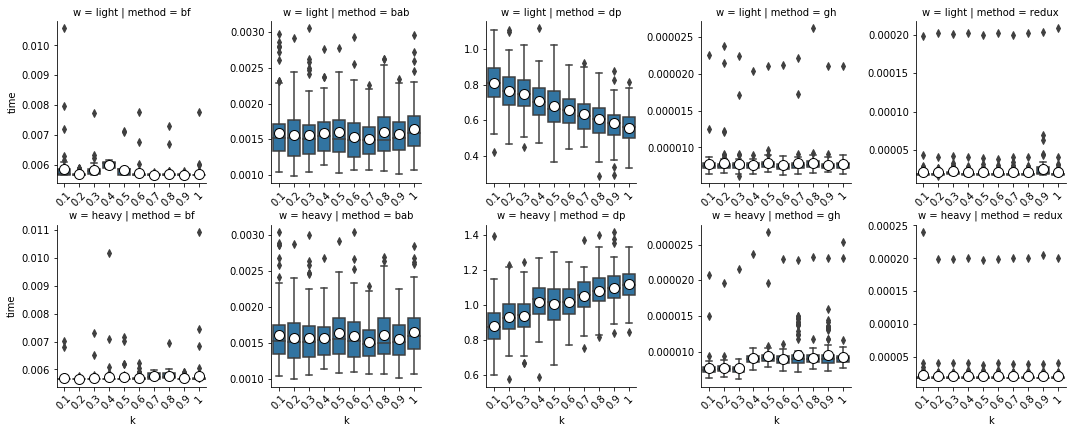

In [44]:
data_ks.seeBoxplotFull("time")

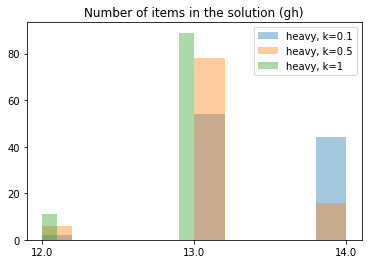

In [49]:
df = data_ks.sol_df
# method = "redux"
method = "gh"
xticks = []

arr_k_01 = []
for l in df[(df["method"] == method) & (df["w"] == "heavy") & (df["k"] == 0.1)]["solution"].values:
    arr_k_01.append(sum(l))
xticks.extend(list(set(arr_k_01)))
ax = sns.distplot(arr_k_01, bins=10, kde=False, label="heavy, k=0.1")

arr_k_05 = []
for l in df[(df["method"] == method) & (df["w"] == "heavy") & (df["k"] == 0.5)]["solution"].values:
    arr_k_05.append(sum(l))
xticks.extend(list(set(arr_k_05)))
ax = sns.distplot(arr_k_05, bins=10, kde=False, label="heavy, k=0.5")

arr_k_1 = []
for l in df[(df["method"] == method) & (df["w"] == "heavy") & (df["k"] == 1)]["solution"].values:
    arr_k_1.append(sum(l))
xticks.extend(list(set(arr_k_1)))
ax = sns.distplot(arr_k_1, bins=10, kde=False, label="heavy, k=1")

xticks = list(set(xticks))
ax.set(xticks=xticks, xticklabels=xticks)
ax.set_title(f"Number of items in the solution ({method})")

plt.legend()
plt.savefig(f"{data_ms.figures_path}/k_number_of_items_in_solution_{method}.png")


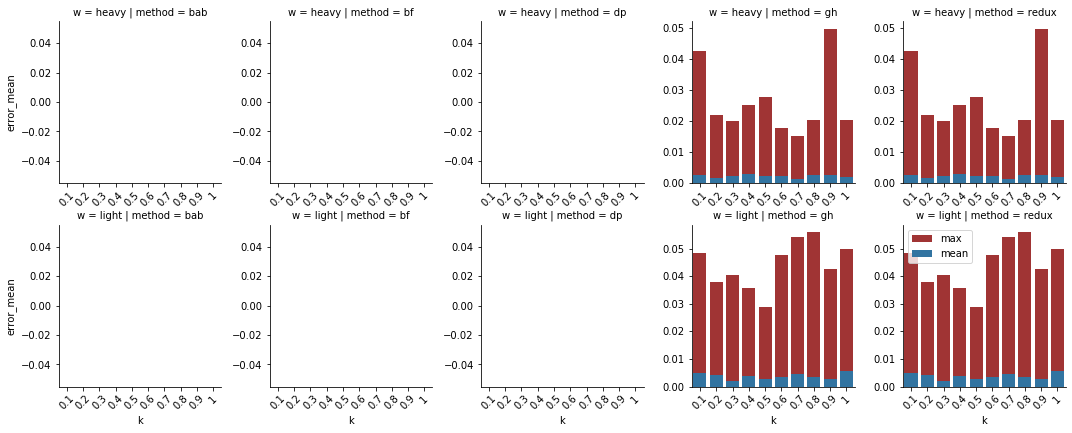

In [50]:
data_ks.seeErrorBarplot()

## Permutations

In [67]:
data_ps = ParamTest(["p"], path=f"{DATA_PATH}/ps", values=PS_VALUES)

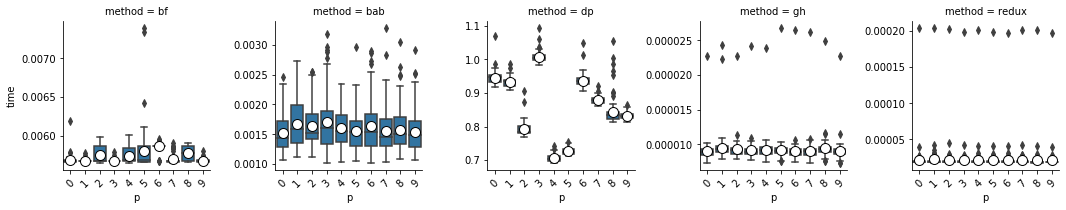

In [70]:
data_ps.seeBoxplotFull("time")

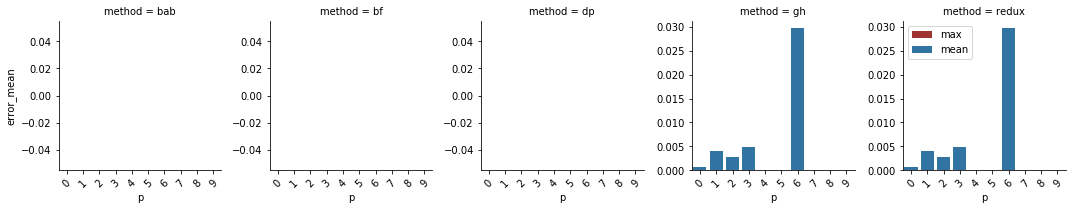

In [72]:
data_ps.seeErrorBarplot()

## Maximum Item Weight

In [54]:
data_Ws = ParamTest(["W"], path=f"{DATA_PATH}/Ws", values=BIG_WS_VALUES)

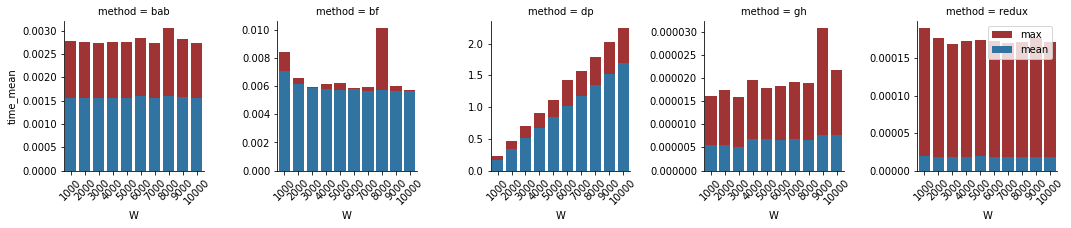

In [55]:
data_Ws.seeTimeBarplot()

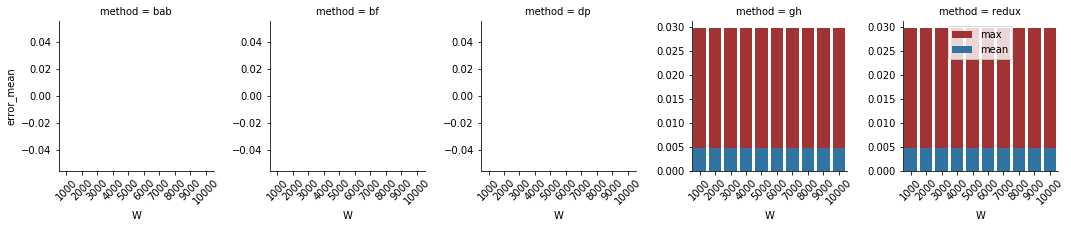

In [57]:
data_Ws.seeErrorBarplot()

## Maximum Item Value

In [58]:
data_Cs = ParamTest(["C"], path=f"{DATA_PATH}/Cs", values=BIG_CS_VALUES)

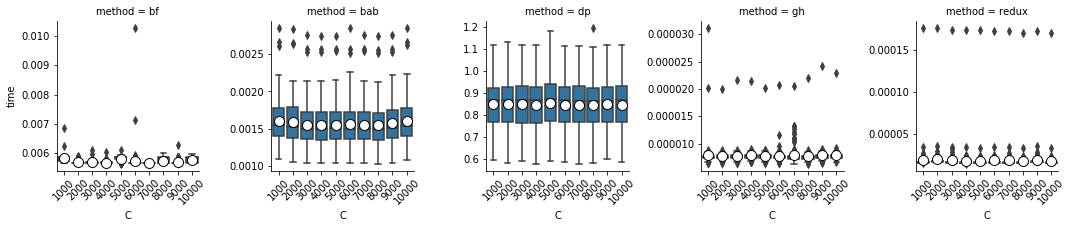

In [60]:
data_Cs.seeBoxplotFull("time")

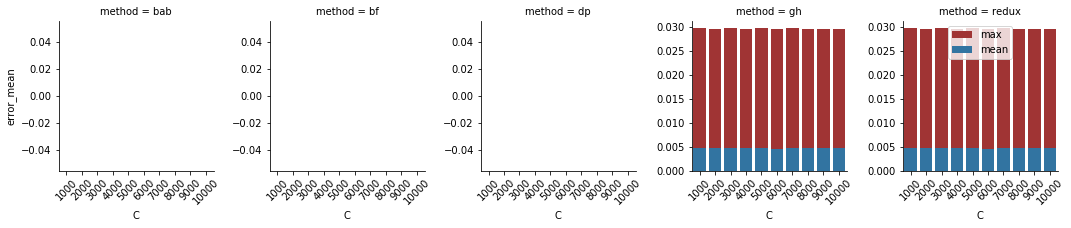

In [66]:
data_Cs.seeErrorBarplot()